
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 微積分

:ラベル: `sec_calculus`

長い間、円の面積を計算する方法は謎のままでした。次に、古代ギリシャの数学者アルキメデスは、円の内側に頂点の数を増やした一連の多角形を書き込むという賢いアイデアを思いつきました (:numref: `fig_circle_area` )。 $n$ 個の頂点を持つ多角形の場合、$n$ 個の三角形が得られます。円をより細かく分割すると、各三角形の高さは半径 $r$ に近づきます。同時に、頂点の数が多いと円弧と割線の比が 1 に近づくため、その底辺は $2 \pi r/n$ に近づきます。したがって、多角形の面積は $n \cdot r \cdot \frac{1}{2} (2 \pi r/n) = \pi r^2$ に近づきます。 

![](../img/polygon-circle.svg) :label: `fig_circle_area`

この制限手順により、*微分積分*と*積分計算*の両方が行われます (:numref: `sec_integral_calculus` )。前者は、引数を操作して関数の値を増減する方法を教えてくれます。これは、損失関数を減らすためにパラメータを繰り返し更新する深層学習で直面する*最適化問題*に役立ちます。最適化は、モデルをトレーニング データに適合させる方法を扱います。微積分はその重要な前提条件です。ただし、私たちの最終的な目標は、*これまでに見たことのない*データで適切なパフォーマンスを発揮することであることを忘れないでください。この問題は*一般化*と呼ばれ、他の章で主に焦点を当てます。


In [1]:
%matplotlib inline
import numpy as np
from matplotlib_inline import backend_inline
from d2l import torch as d2l


## 微分と微分

簡単に言えば、*導関数*は、引数の変化に対する関数の変化率です。微分関数を使用すると、各パラメーターを微小量だけ*増減*した場合に、損失関数がどの程度の速さで*増減*するかを知ることができます。正式には、スカラーからスカラーにマッピングする関数 $f: \mathbb{R} \rightarrow \mathbb{R}$ について、[**点 $x$ における $f$ の*導関数*は次のように定義されます**]

 **( $$f&#39;(x) = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h}.$$ ) :eqlabel:** `eq_derivative`

右側のこの項は*限界*と呼ばれ、指定された変数が特定の値に近づくと式の値に何が起こるかを示します。この制限は、摂動 $h$ と関数値の変化 $f(x + h) - f(x)$ の比率が、そのサイズをゼロに縮小したときにどの程度に収束するかを示します。

 $f&#39;(x)$ が存在する場合、$f$ は $x$ で*微分可能で*あると言われます。そして、集合上のすべての $x$、たとえば区間 $[a,b]$ に対して $f&#39;(x)$ が存在するとき、$f$ はこの集合上で微分可能であると言います。すべての関数が微分可能であるわけではありません。精度や受信動作特性 (AUC) 下の領域など、最適化したい関数も多く含まれます。ただし、損失の導関数の計算は、ディープ ニューラル ネットワークをトレーニングするためのほぼすべてのアルゴリズムにおいて重要なステップであるため、多くの場合、代わりに微分可能な*サロゲート*を最適化します。

導関数 $f&#39;(x)$ は、$x$ に対する $f(x)$ の*瞬間的な*変化率として解釈できます。例を挙げて直感を養いましょう。 ( **$u = f(x) = 3x^2-4x$ と定義します。** )


In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x


[ **Set $x=1$, $\frac{f(x+h) - f(x)}{h}$** ] ( **$h$ が $0$ に近づくと、$2$ に近づきます。** ) ただし、この実験は厳密さを欠いています。数学的な証明により、実際に $f&#39;(1) = 2$ であることがすぐにわかります。


In [3]:
for h in 10.0**np.arange(-1, -6, -1):
    print(f'h={h:.5f}, numerical limit={(f(1+h)-f(1))/h:.5f}')

h=0.10000, numerical limit=2.30000
h=0.01000, numerical limit=2.03000
h=0.00100, numerical limit=2.00300
h=0.00010, numerical limit=2.00030
h=0.00001, numerical limit=2.00003



導関数には、同等の表記規則がいくつかあります。 $y = f(x)$ とすると、次の式は等価です。

 $$f&#39;(x) = y&#39; = \frac{dy}{dx} = \frac{df}{dx} = \frac{d}{dx} f(x) = Df(x) = D_x f( x)、$$

ここで、記号 $\frac{d}{dx}$ と $D$ は*微分演算子*です。以下に、いくつかの一般的な関数の導関数を示します。

 $$\begin{aligned} \frac{d}{dx} C &amp; = 0 &amp;&amp; \text{任意の定数 $C$ について} \ \frac{d}{dx} x^n &amp; = nx^{n-1 } &amp;&amp; \text{for } n \neq 0 \ \frac{d}{dx} e^x &amp; = e^x \ \frac{d}{dx} \ln x &amp; = x^{-1} \end {整列}$$

微分可能な関数から構成される関数は、多くの場合それ自体が微分可能です。次のルールは、微分可能な関数 $f$ と $g$、および定数 $C$ の合成を扱う場合に便利です。

 $$\begin{aligned} \frac{d}{dx} [C f(x)] &amp; = C \frac{d}{dx} f(x) &amp;&amp; \text{定数倍則} \ \frac{d }{dx} [f(x) + g(x)] &amp; = \frac{d}{dx} f(x) + \frac{d}{dx} g(x) &amp;&amp; \text{合計ルール} \ \frac{d}{dx} [f(x) g(x)] &amp; = f(x) \frac{d}{dx} g(x) + g(x) \frac{d}{dx} f (x) &amp;&amp; \text{積則} \ \frac{d}{dx} \frac{f(x)}{g(x)} &amp; = \frac{g(x) \frac{d}{dx} f(x) - f(x) \frac{d}{dx} g(x)}{g^2(x)} &amp;&amp; \text{商ルール} \end{aligned}$$

これを使用すると、次のようにルールを適用して $3 x^2 - 4x$ の導関数を見つけることができます。

 $$\frac{d}{dx} [3 x^2 - 4x] = 3 \frac{d}{dx} x^2 - 4 \frac{d}{dx} x = 6x - 4.$$

 $x = 1$ を代入すると、実際にこの位置で導関数が $2$ であることがわかります。導関数により、特定の位置における関数の*傾きが*わかることに注意してください。

## 視覚化ユーティリティ

[ **`matplotlib`ライブラリを使用して関数の傾きを視覚化できます**]。いくつかの関数を定義する必要があります。名前が示すように、 `use_svg_display` 、より鮮明な画像を得るために SVG 形式でグラフィックスを出力するように`matplotlib`に指示します。コメント`#@save`任意の関数、クラス、またはその他のコード ブロックを`d2l`パッケージに保存できるようにする特別な修飾子です。これにより、コードを繰り返さずに後で呼び出すことができます (たとえば`d2l.use_svg_display()`など)。


In [4]:
def use_svg_display():  #@save
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')


便利なことに、 `set_figsize`使用して Figure のサイズを設定できます。 `from matplotlib import pyplot as plt` import ステートメントは`d2l`パッケージ内の`#@save`によってマークされているため、 `d2l.plt`を呼び出すことができます。


In [5]:
def set_figsize(figsize=(3.5, 2.5)):  #@save
    """Set the figure size for matplotlib."""
    use_svg_display()
    d2l.plt.rcParams['figure.figsize'] = figsize


`set_axes`関数は、軸をラベル、範囲、スケールなどのプロパティに関連付けることができます。


In [6]:
#@save
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


これら 3 つの関数を使用して、複数の曲線をオーバーレイする`plot`関数を定義できます。ここでのコードの多くは、入力のサイズと形状が一致していることを確認するだけです。


In [7]:
#@save
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""

    def has_one_axis(X):  # True if X (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    set_figsize(figsize)
    if axes is None:
        axes = d2l.plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)


これで、[**関数 $u = f(x)$ とその接線 $y = 2x - 3$ を $x=1$ にプロット] することが**できます。ここで、係数 $2$ は接線の傾きです。


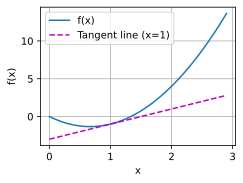

In [8]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])


## 偏導関数と勾配

:label: `subsec_calculus-grad`

これまでは、1 つの変数のみの関数を微分してきました。深層学習では、*多くの*変数の関数を扱う必要もあります。このような*多変量*関数に適用される導関数の概念を簡単に紹介します。

 $y = f(x_1, x_2, \ldots, x_n)$ を $n$ 変数を持つ関数としましょう。 $i^\mathrm{th}$ パラメータ $x_i$ に関する $y$ の*偏微分は*次のようになります。

 $$ \frac{\partial y}{\partial x_i} = \lim_{h \rightarrow 0} \frac{f(x_1, \ldots, x_{i-1}, x_i+h, x_{i+1} , \ldots, x_n) - f(x_1, \ldots, x_i, \ldots, x_n)}{h}.$$

 $\frac{\partial y}{\partial x_i}$ を計算するには、$x_1、\ldots、x_{i-1}、x_{i+1}、\ldots、x_n$ を定数として扱い、 $x_i$ に関する $y$ の導関数。偏導関数の次の表記規則はすべて共通であり、すべて同じことを意味します。

 $$\frac{\partial y}{\partial x_i} = \frac{\partial f}{\partial x_i} = \partial_{x_i} f = \partial_i f = f_{x_i} = f_i = D_i f = D_ {x_i} f.$$

多変量関数のすべての変数に関して偏導関数を連結して、関数の*勾配*と呼ばれるベクトルを取得できます。関数 $f: \mathbb{R}^n \rightarrow \mathbb{R}$ の入力が $n$ 次元ベクトル $\mathbf{x} = [x_1, x_2, \ldots, x_n]^ であるとします。 \top$ であり、出力はスカラーです。 $\mathbf{x}$ に関する関数 $f$ の勾配は、$n$ 偏導関数のベクトルです。

 $$\nabla_{\mathbf{x}} f(\mathbf{x}) = \left[\partial_{x_1} f(\mathbf{x}), \partial_{x_2} f(\mathbf{x}) , \ldots \partial_{x_n} f(\mathbf{x})\right]^\top.$$

あいまいさがない場合、通常、$\nabla_{\mathbf{x}} f(\mathbf{x})$ は $\nabla f(\mathbf{x})$ に置き換えられます。次のルールは、多変量関数を微分する場合に役立ちます。
- すべての $\mathbf{A} \in \mathbb{R}^{m \times n}$ に対して、 $\nabla_{\mathbf{x}} \mathbf{A} \mathbf{x} = \mathbf{A }^\top$ と $\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{A} = \mathbf{A}$。
- 正方行列 $\mathbf{A} \in \mathbb{R}^{n \times n}$ の場合、 $\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{A} が得られます。 \mathbf{x} = (\mathbf{A} + \mathbf{A}^\top)\mathbf{x}$、特に $\nabla_{\mathbf{x}} |\mathbf{x} |^2 = \nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{x} = 2\mathbf{x}$。

同様に、任意の行列 $\mathbf{X}$ については、$\nabla_{\mathbf{X}} |\mathbf{X} |_F^2 = 2\mathbf{X}$ となります。

## 連鎖法則

深層学習では、深く入れ子になった関数 (関数の (関数の...)) を扱うため、関係する勾配の計算が難しいことがよくあります。幸いなことに、*連鎖ルールが*これに対処します。単一変数の関数に戻って、$y = f(g(x))$ と、基礎となる関数 $y=f(u)$ および $u=g(x)$ が両方とも微分可能であると仮定します。連鎖の法則は次のように述べています。

 $$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}.$$

多変量関数に戻って、$y = f(\mathbf{u})$ に変数 $u_1、u_2、\ldots、u_m$ があり、各 $u_i = g_i(\mathbf{x})$ に変数 $ があるとします。 x_1、x_2、\ldots、x_n$、つまり $\mathbf{u} = g(\mathbf{x})$。次に、連鎖規則は次のように述べます。

 $$\frac{\partial y}{\partial x_{i}} = \frac{\partial y}{\partial u_{1}} \frac{\partial u_{1}}{\partial x_{i} } + \frac{\partial y}{\partial u_{2}} \frac{\partial u_{2}}{\partial x_{i}} + \ldots + \frac{\partial y}{\partial u_ {m}} \frac{\partial u_{m}}{\partial x_{i}} \text{ したがって、 } \nabla_{\mathbf{x}} y = \mathbf{A} \nabla_{\mathbf{ u}} y,$$

ここで $\mathbf{A} \in \mathbb{R}^{n \times m}$ は、ベクトル $\mathbf{x}$ に関するベクトル $\mathbf{u}$ の導関数を含む*行列*です。したがって、勾配を評価するには、ベクトルと行列の積を計算する必要があります。これが、線形代数が深層学習システムの構築において不可欠な構成要素である主な理由の 1 つです。

## 議論

深いトピックの表面をなぞっただけですが、多くの概念がすでに焦点になっています。まず、微分のための合成ルールを無意識に適用でき、勾配を*自動的に*計算できるようになります。このタスクには創造性が必要ないため、認知力を別のことに集中できます。第 2 に、ベクトル値関数の導関数を計算するには、変数の依存関係グラフを出力から入力まで追跡しながら行列を乗算する必要があります。特に、このグラフは、関数を評価するときは*順方向*に走査され、勾配を計算するときは*逆*方向に走査されます。後の章では、連鎖則を適用するための計算手順であるバックプロパゲーションを正式に紹介します。

最適化の観点から見ると、勾配を使用すると、損失を下げるためにモデルのパラメーターを移動する方法を決定できます。また、本書全体で使用される最適化アルゴリズムの各ステップでは、勾配を計算する必要があります。

## 演習
1. これまで私たちはデリバティブのルールを当然のことだと考えていました。定義と極限を使用して、(i) $f(x) = c$、(ii) $f(x) = x^n$、(iii) $f(x) = e^x$、および ( iv) $f(x) = \log x$。
1. 同様に、積、和、商の法則を第一原理から証明します。
1. 積規則の特殊な場合として、定数倍規則が成り立つことを証明します。
1.  $f(x) = x^x$ の導関数を計算します。
1. ある $x$ に対して $f&#39;(x) = 0$ というのは何を意味するのでしょうか?これが成り立つ関数 $f$ と位置 $x$ の例を挙げてください。
1. 関数 $y = f(x) = x^3 - \frac{1}{x}$ をプロットし、その接線を $x = 1$ にプロットします。
1. 関数 $f(\mathbf{x}) = 3x_1^2 + 5e^{x_2}$ の勾配を求めます。
1. 関数 $f(\mathbf{x}) = |\mathbf{x}|_2$ の勾配はいくらですか? $\mathbf{x} = \mathbf{0}$ の場合はどうなりますか?
1.  $u = f(x, y, z)$ および $x = x(a, b)$、$y = y(a, b)$、および $z = の場合の連鎖規則を書き出していただけますか? z(a, b)$?
1. 可逆な関数 $f(x)$ が与えられた場合、その逆関数 $f^{-1}(x)$ の導関数を計算します。ここでは $f^{-1}(f(x)) = x$ 、逆に $f(f^{-1}(y)) = y$ となります。ヒント: 導出にはこれらのプロパティを使用してください。



[ディスカッション](https://discuss.d2l.ai/t/33)
